# Feature Engineering and Transformation Script for Movie Dropoff Prediction

## Objective
Create a comprehensive feature engineering pipeline that transforms and engineers features from the seeded survey data to maximize prediction accuracy for movie dropoff behavior. This notebook implements multiple feature selection techniques and provides detailed analysis of feature importance.

## Dataset Context
- **File**: `seeded_survey_data.csv`
- **Target Variable**: Movie completion behavior (derived from survey responses)
- **Features**: Survey responses including demographics, viewing habits, preferences, and behavioral patterns
- **Data Types**: Mix of categorical (ordinal/nominal), numerical, and binary encoded features

## Implementation Overview
1. **Data Preprocessing**: Load, clean, and prepare the dataset
2. **Feature Engineering**: Create new meaningful features from existing data
3. **Feature Selection**: Implement and compare multiple selection methods (RFE, Chi-Square, Mutual Information, Lasso)
4. **Experimental Framework**: Systematic testing of different feature combinations
5. **Model Validation**: Cross-validation and performance evaluation
6. **Analysis & Visualization**: Feature importance analysis and comparison

In [21]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE, chi2, SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.cluster import KMeans
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("All libraries imported successfully!")
print("Python version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", end=" ")
import sklearn
print(sklearn.__version__)

All libraries imported successfully!
Python version: 2.3.1
Pandas version: 2.3.1
Scikit-learn version: 1.6.1


## 1. Data Loading and Initial Exploration

Let's load the seeded survey data and examine its structure to understand the features and target variable.

In [22]:
# Load the dataset
df = pd.read_csv('seeded_survey_data.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (78, 96)

Column Names:
['Timestamp', 'What is your age group?', 'What is your gender?', 'What is the highest level of education you’ve completed? ', 'How often do you watch movies?', 'Which genres do you enjoy watching the most?  (Select up to 3)', 'How do you usually discover movies you decide to watch? (Select all that apply)', 'Where do you usually watch movies? (Select all that apply)', 'Who do you usually watch movies with?', 'What is your typical mood before watching a movie?', 'Why do you usually choose to watch movies? (Select all that apply)', 'In general, what are the main reasons you stop watching movies before finishing? (Select all that apply)', 'When you stop watching a movie, how often do you go back to finish it later?', 'Have you ever started watching a movie but did not finish it?', 'How often do you stop watching movies before finishing them?', 'Which genres do you find yourself stopping more often before finishing? (Select all that apply)', 'Thinking

,Timestamp,What is your age group?,What is your gender?,What is the highest level of education you’ve completed?,How often do you watch movies?,Which genres do you enjoy watching the most? (Select up to 3),How do you usually discover movies you decide to watch? (Select all that apply),Where do you usually watch movies? (Select all that apply),Who do you usually watch movies with?,What is your typical mood before watching a movie?,Why do you usually choose to watch movies? (Select all that apply),"In general, what are the main reasons you stop watching movies before finishing? (Select all that apply)","When you stop watching a movie, how often do you go back to finish it later?",Have you ever started watching a movie but did not finish it?,How often do you stop watching movies before finishing them?,Which genres do you find yourself stopping more often before finishing? (Select all that apply),"Thinking about movies you have started but did not finish, at what point do you usually stop watching?",How often do you typically pause or stop the movie during viewing?,Do you usually skip any scenes when watching movies?,"Can you recall a specific movie you started but did not finish? If yes, please name it (optional):",What was the main reason you stopped watching that movie?,How likely are you to resume or finish that movie later?,Any additional comments about your experience with movies you stopped watching?,Why do you usually pause the movie? (Select all that apply),How often do you return to watching a movie you didn’t finish?,What device do you usually watch movies on?,Do you usually do other things while watching movies? (Select all that apply),"When watching movies, do you usually watch at the normal speed or skip parts of the movie?",which_genres_do_you_enjoy_watching_the_most_action,which_genres_do_you_enjoy_watching_the_most_comedy,which_genres_do_you_enjoy_watching_the_most_drama,which_genres_do_you_enjoy_watching_the_most_horror,which_genres_do_you_enjoy_watching_the_most_romance,which_genres_do_you_enjoy_watching_the_most_science_fiction_sci_fi,which_genres_do_you_enjoy_watching_the_most_documentary,which_genres_do_you_enjoy_watching_the_most_thriller,which_genres_do_you_enjoy_watching_the_most_historical,how_do_you_usually_discover_movies_you_decide_to_watch_trailer,how_do_you_usually_discover_movies_you_decide_to_watch_friend_family_recommendation,how_do_you_usually_discover_movies_you_decide_to_watch_social_media,how_do_you_usually_discover_movies_you_decide_to_watch_streaming_platform_suggestion,how_do_you_usually_discover_movies_you_decide_to_watch_reviews_or_ratings,how_do_you_usually_discover_movies_you_decide_to_watch_recently_trending_or_popular_movies,where_do_you_usually_watch_movies_streaming_at_home_netflix_disney+_etc.,where_do_you_usually_watch_movies_in_a_cinema_theater,where_do_you_usually_watch_movies_downloaded_or_offline_video_files,where_do_you_usually_watch_movies_streaming_on_mobile_while_out_e.g._commuting,why_do_you_usually_choose_to_watch_movies_entertainment,why_do_you_usually_choose_to_watch_movies_recommendation_from_friends_or_family,why_do_you_usually_choose_to_watch_movies_favorite_actors_or_directors,why_do_you_usually_choose_to_watch_movies_interesting_storyline_or_genre,why_do_you_usually_choose_to_watch_movies_trailer_or_promotional_material,why_do_you_usually_choose_to_watch_movies_awards_or_critical_acclaim,why_do_you_usually_choose_to_watch_movies_recently_trending,why_do_you_usually_choose_to_watch_movies_to_relax_or_unwind,in_general_what_are_the_main_reasons_you_stop_watching_movies_before_finishing_boring_uninteresting_plot,in_general_what_are_the_main_reasons_you_stop_watching_movies_before_finishing_poor_acting_or_characters,in_general_what_are_the_main_reasons_you_stop_watching_movies_before_finishing_too_long_slow_pacing,in_general_what_are_the_main_reasons_you_stop_watching_movies_before_finishing_technical_issues_buffering_audio_etc.,in_general_what_are_the_main_reasons_yo

In [23]:
# Data inspection and missing values
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\nData Types:")
print(df.dtypes.value_counts())

print("\nUnique values in key columns:")
categorical_cols = ['What is your age group?', 'What is your gender?', 
                   'How often do you watch movies?', 'Have you ever started watching a movie but did not finish it?',
                   'How often do you stop watching movies before finishing them?']
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 96 columns):
 #   Column                                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                                --------------  ----- 
 0   Timestamp                                                                                                             78 non-null     object
 1   What is your age group?                                                                                               77 non-null     object
 2   What is your gender?                                                                                                  77 non-null     object
 3   What is the highest level of education you’ve completed?                                                              77 non-null     object
 4   Ho

In [24]:
# Create target variable based on movie completion behavior
# We'll use the "How often do you stop watching movies before finishing them?" as our primary target
# and supplement with other completion-related questions

def create_target_variable(df):
    """
    Create a binary target variable for movie completion behavior
    0 = Tends to finish movies (low dropoff probability)
    1 = Tends to drop off movies (high dropoff probability)
    """
    # Primary indicator: frequency of stopping movies
    frequency_map = {
        'Never': 0,
        'Rarely': 0,
        'Sometimes': 1,
        'Often': 1
    }
    
    # Create base target from frequency
    target = df['How often do you stop watching movies before finishing them?'].map(frequency_map)
    
    # Add weight from "Have you ever started watching a movie but did not finish it?"
    never_unfinished = df['Have you ever started watching a movie but did not finish it?'] == 'No'
    target = target.fillna(0)  # Fill any NaN values
    target[never_unfinished] = 0  # If never unfinished, set to 0
    
    return target

# Create target variable
y = create_target_variable(df)
print("Target variable distribution:")
print(y.value_counts())
print(f"\nTarget variable balance: {y.mean():.2%} positive class (dropoff tendency)")

# Add target to dataframe for analysis
df['target_dropoff'] = y

Target variable distribution:
How often do you stop watching movies before finishing them?
1.0    50
0.0    28
Name: count, dtype: int64

Target variable balance: 64.10% positive class (dropoff tendency)


## 2. Feature Categorization and Preprocessing

Let's identify and categorize different types of features in our dataset for appropriate preprocessing.

In [25]:
# Categorize features by type
def categorize_features(df):
    """
    Categorize features into different types for appropriate preprocessing
    """
    # Exclude target and movie title columns
    exclude_cols = ['target_dropoff', 'Timestamp', 'finished_1', 'finished_2', 'finished_3', 
                   'finished_4', 'finished_5', 'unfinished_1', 'unfinished_2', 'unfinished_3', 
                   'unfinished_4', 'unfinished_5']
    
    # Binary encoded features (0/1)
    binary_features = [col for col in df.columns if col.startswith(('which_genres', 'how_do_you', 
                       'where_do_you', 'why_do_you', 'in_general', 'do_you_usually'))]
    
    # Categorical features (text responses)
    categorical_features = [
        'What is your age group?',
        'What is your gender?',
        'What is the highest level of education you\'ve completed? ',
        'How often do you watch movies?',
        'Who do you usually watch movies with?',
        'What is your typical mood before watching a movie?',
        'When you stop watching a movie, how often do you go back to finish it later?',
        'Have you ever started watching a movie but did not finish it?',
        'How often do you stop watching movies before finishing them?',
        'Thinking about movies you have started but did not finish, at what point do you usually stop watching?',
        'How often do you typically pause or stop the movie during viewing?',
        'Do you usually skip any scenes when watching movies?',
        'What was the main reason you stopped watching that movie?',
        'How likely are you to resume or finish that movie later?',
        'How often do you return to watching a movie you didn\'t finish?',
        'What device do you usually watch movies on?',
        'When watching movies, do you usually watch at the normal speed or skip parts of the movie?'
    ]
    
    # Text features (free form responses)
    text_features = [
        'Which genres do you enjoy watching the most?  (Select up to 3)',
        'How do you usually discover movies you decide to watch? (Select all that apply)',
        'Where do you usually watch movies? (Select all that apply)',
        'Why do you usually choose to watch movies? (Select all that apply)',
        'In general, what are the main reasons you stop watching movies before finishing? (Select all that apply)',
        'Which genres do you find yourself stopping more often before finishing? (Select all that apply)',
        'Can you recall a specific movie you started but did not finish? If yes, please name it (optional):',
        'Any additional comments about your experience with movies you stopped watching?',
        'Why do you usually pause the movie? (Select all that apply)',
        'Do you usually do other things while watching movies? (Select all that apply)'
    ]
    
    # Filter to only include columns that exist in the dataframe
    categorical_features = [col for col in categorical_features if col in df.columns]
    text_features = [col for col in text_features if col in df.columns]
    binary_features = [col for col in binary_features if col in df.columns]
    
    return {
        'binary': binary_features,
        'categorical': categorical_features,
        'text': text_features,
        'exclude': exclude_cols
    }

feature_categories = categorize_features(df)
print("Feature Categories:")
print(f"Binary features: {len(feature_categories['binary'])}")
print(f"Categorical features: {len(feature_categories['categorical'])}")
print(f"Text features: {len(feature_categories['text'])}")
print(f"Excluded features: {len(feature_categories['exclude'])}")

print("\nBinary features (first 10):")
print(feature_categories['binary'][:10])
print("\nCategorical features:")
print(feature_categories['categorical'][:10])
print("\nText features:")
print(feature_categories['text'][:5])

Feature Categories:
Binary features: 58
Categorical features: 15
Text features: 10
Excluded features: 12

Binary features (first 10):
['which_genres_do_you_enjoy_watching_the_most_action', 'which_genres_do_you_enjoy_watching_the_most_comedy', 'which_genres_do_you_enjoy_watching_the_most_drama', 'which_genres_do_you_enjoy_watching_the_most_horror', 'which_genres_do_you_enjoy_watching_the_most_romance', 'which_genres_do_you_enjoy_watching_the_most_science_fiction_sci_fi', 'which_genres_do_you_enjoy_watching_the_most_documentary', 'which_genres_do_you_enjoy_watching_the_most_thriller', 'which_genres_do_you_enjoy_watching_the_most_historical', 'how_do_you_usually_discover_movies_you_decide_to_watch_trailer']

Categorical features:
['What is your age group?', 'What is your gender?', 'How often do you watch movies?', 'Who do you usually watch movies with?', 'What is your typical mood before watching a movie?', 'When you stop watching a movie, how often do you go back to finish it later?', 'H

## 3. Feature Engineering

Now let's create new meaningful features from the existing data to improve model performance.

In [26]:
def create_engineered_features(df):
    """
    Create new features from existing data
    """
    df_eng = df.copy()
    
    # 1. Aggregation Features
    # Total genre preferences
    genre_cols = [col for col in df.columns if col.startswith('which_genres_do_you_enjoy')]
    df_eng['total_genres_enjoyed'] = df[genre_cols].sum(axis=1)
    
    # Total viewing behaviors
    viewing_cols = [col for col in df.columns if col.startswith('do_you_usually_do_other_things')]
    df_eng['total_multitasking_behaviors'] = df[viewing_cols].sum(axis=1)
    
    # Total reasons for stopping
    stopping_cols = [col for col in df.columns if col.startswith('in_general_what_are_the_main_reasons')]
    df_eng['total_stopping_reasons'] = df[stopping_cols].sum(axis=1)
    
    # Total discovery methods
    discovery_cols = [col for col in df.columns if col.startswith('how_do_you_usually_discover')]
    df_eng['total_discovery_methods'] = df[discovery_cols].sum(axis=1)
    
    # Total watch locations
    location_cols = [col for col in df.columns if col.startswith('where_do_you_usually_watch')]
    df_eng['total_watch_locations'] = df[location_cols].sum(axis=1)
    
    # 2. Ratio Features
    # Ratio of genres stopped vs enjoyed
    stopped_genre_cols = [col for col in df.columns if col.startswith('which_genres_do_you_find_yourself_stopping')]
    df_eng['total_genres_stopped'] = df[stopped_genre_cols].sum(axis=1)
    df_eng['genre_completion_ratio'] = df_eng['total_genres_stopped'] / (df_eng['total_genres_enjoyed'] + 1)
    
    # Attention span score (lower = shorter attention span)
    attention_indicators = [
        'do_you_usually_do_other_things_while_watching_movies_i_scroll_on_my_phone_or_use_social_media',
        'do_you_usually_do_other_things_while_watching_movies_i_chat_or_text_with_others',
        'do_you_usually_do_other_things_while_watching_movies_i_work_or_study_while_watching'
    ]
    attention_score = 0
    for col in attention_indicators:
        if col in df.columns:
            attention_score += df[col]
    df_eng['attention_span_score'] = 1 / (attention_score + 1)  # Higher score = better attention
    
    # 3. Interaction Features
    # Genre-behavior interactions (example: action + multitasking)
    if 'which_genres_do_you_enjoy_watching_the_most_action' in df.columns:
        df_eng['action_multitasking_interaction'] = (
            df['which_genres_do_you_enjoy_watching_the_most_action'] * 
            df_eng['total_multitasking_behaviors']
        )
    
    # Social viewing pattern
    social_cols = [col for col in df.columns if 'friend' in col.lower() or 'family' in col.lower() or 'social' in col.lower()]
    df_eng['social_influence_score'] = df[social_cols].sum(axis=1) if social_cols else 0
    
    # 4. Behavioral Scores
    # Engagement score (high = more engaged viewer)
    engagement_factors = []
    if 'How often do you watch movies?' in df.columns:
        watch_freq_map = {
            'Rarely (about once per month)': 1,
            'A few times a month (2-3 times per month)': 2,
            'Once a week': 3,
            'Several times a week (3–6 times a week)': 4,
            'Daily (at least 1 movie per day)': 5
        }
        df_eng['watch_frequency_score'] = df['How often do you watch movies?'].map(watch_freq_map).fillna(0)
        engagement_factors.append('watch_frequency_score')
    
    # Patience score (high = more patient viewer)
    patience_indicators = [
        'in_general_what_are_the_main_reasons_you_stop_watching_movies_before_finishing_too_long_slow_pacing',
        'in_general_what_are_the_main_reasons_you_stop_watching_movies_before_finishing_boring_uninteresting_plot'
    ]
    patience_score = 0
    for col in patience_indicators:
        if col in df.columns:
            patience_score += df[col]
    df_eng['patience_score'] = 1 / (patience_score + 1)
    
    # 5. Clustering Features
    # Create user behavior clusters based on viewing patterns
    cluster_features = ['total_genres_enjoyed', 'total_multitasking_behaviors', 
                       'total_stopping_reasons', 'attention_span_score']
    cluster_data = df_eng[cluster_features].fillna(0)
    
    # Normalize for clustering
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    # Create clusters
    kmeans = KMeans(n_clusters=3, random_state=42)
    df_eng['behavior_cluster'] = kmeans.fit_predict(cluster_data_scaled)
    
    # 6. Temporal Features (if timestamp available)
    if 'Timestamp' in df.columns:
        df_eng['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df_eng['hour_of_day'] = df_eng['Timestamp'].dt.hour
        df_eng['day_of_week'] = df_eng['Timestamp'].dt.dayofweek
        df_eng['is_weekend'] = (df_eng['day_of_week'] >= 5).astype(int)
    
    return df_eng

# Apply feature engineering
df_engineered = create_engineered_features(df)

print("Original features:", df.shape[1])
print("After feature engineering:", df_engineered.shape[1])
print("New features created:", df_engineered.shape[1] - df.shape[1])

# Show new features
new_features = [col for col in df_engineered.columns if col not in df.columns]
print("\nNew features created:")
for feature in new_features:
    print(f"- {feature}")
    
# Basic statistics of new features
print("\nNew feature statistics:")
print(df_engineered[new_features].describe())

Original features: 97
After feature engineering: 113
New features created: 16

New features created:
- total_genres_enjoyed
- total_multitasking_behaviors
- total_stopping_reasons
- total_discovery_methods
- total_watch_locations
- total_genres_stopped
- genre_completion_ratio
- attention_span_score
- action_multitasking_interaction
- social_influence_score
- watch_frequency_score
- patience_score
- behavior_cluster
- hour_of_day
- day_of_week
- is_weekend

New feature statistics:
       total_genres_enjoyed  total_multitasking_behaviors  \
count             78.000000                     78.000000   
mean               3.794872                      1.948718   
std                1.514938                      1.204940   
min                0.000000                      0.000000   
25%                3.000000                      1.000000   
50%                3.000000                      2.000000   
75%                5.000000                      3.000000   
max                9.00000

## 4. Feature Discretization and Transformation

Discretization (binning) is a crucial transformation technique that converts continuous variables into discrete categories. This can improve model performance by capturing non-linear relationships and reducing noise.

In [27]:
from sklearn.preprocessing import KBinsDiscretizer
from scipy import stats
import warnings

def apply_discretization(df_eng):
    """
    Apply various discretization techniques to continuous features
    """
    df_disc = df_eng.copy()
    
    # Identify continuous features that can benefit from discretization
    continuous_features = [
        'total_genres_enjoyed',
        'total_multitasking_behaviors', 
        'total_stopping_reasons',
        'total_discovery_methods',
        'total_watch_locations',
        'total_genres_stopped',
        'genre_completion_ratio',
        'attention_span_score',
        'social_influence_score',
        'watch_frequency_score',
        'patience_score'
    ]
    
    # Filter to only existing features
    continuous_features = [f for f in continuous_features if f in df_disc.columns]
    
    discretization_results = {}
    
    print("Applying discretization methods...")
    print("=" * 50)
    
    for feature in continuous_features:
        print(f"Processing {feature}...")
        
        # Skip if feature has too few unique values
        if df_disc[feature].nunique() < 5:
            print(f"  Skipping {feature} - too few unique values ({df_disc[feature].nunique()})")
            continue
            
        feature_data = df_disc[feature].fillna(df_disc[feature].median())
        
        # 1. Equal-width binning (uniform intervals)
        try:
            discretizer_uniform = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
            uniform_bins = discretizer_uniform.fit_transform(feature_data.values.reshape(-1, 1)).ravel()
            df_disc[f'{feature}_uniform_bins'] = uniform_bins
            
            # 2. Equal-frequency binning (quantile-based)
            discretizer_quantile = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
            quantile_bins = discretizer_quantile.fit_transform(feature_data.values.reshape(-1, 1)).ravel()
            df_disc[f'{feature}_quantile_bins'] = quantile_bins
            
            # 3. K-means clustering based binning
            discretizer_kmeans = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
            kmeans_bins = discretizer_kmeans.fit_transform(feature_data.values.reshape(-1, 1)).ravel()
            df_disc[f'{feature}_kmeans_bins'] = kmeans_bins
            
            # 4. Custom business-logic binning (domain-specific)
            if 'ratio' in feature or 'score' in feature:
                # For ratio/score features, create meaningful thresholds
                if feature_data.max() <= 1:  # Normalized features
                    custom_bins = pd.cut(feature_data, 
                                       bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
                                       include_lowest=True)
                else:
                    # Use percentile-based custom bins
                    percentiles = [0, 25, 50, 75, 100]
                    thresholds = [np.percentile(feature_data, p) for p in percentiles]
                    custom_bins = pd.cut(feature_data, bins=thresholds, 
                                       labels=['Low', 'Medium-Low', 'Medium-High', 'High'],
                                       include_lowest=True, duplicates='drop')
                    
                df_disc[f'{feature}_custom_bins'] = custom_bins.codes
            
            elif 'total' in feature:
                # For count features, use natural breakpoints
                if feature_data.max() <= 10:
                    custom_bins = pd.cut(feature_data, 
                                       bins=[0, 1, 3, 5, 10], 
                                       labels=['None/Single', 'Few', 'Several', 'Many'],
                                       include_lowest=True)
                else:
                    # Use quartile-based bins for higher counts
                    q1, q2, q3 = np.percentile(feature_data, [25, 50, 75])
                    custom_bins = pd.cut(feature_data, 
                                       bins=[feature_data.min()-0.1, q1, q2, q3, feature_data.max()+0.1],
                                       labels=['Low', 'Medium-Low', 'Medium-High', 'High'],
                                       include_lowest=True)
                
                df_disc[f'{feature}_custom_bins'] = custom_bins.codes
            
            # 5. Optimal binning based on target variable (supervised)
            # This finds cut points that maximize the chi-square statistic with target
            def optimal_binning_chi2(feature_data, target, max_bins=5):
                """Find optimal cut points using chi-square test"""
                try:
                    best_score = 0
                    best_bins = None
                    
                    # Try different numbers of bins
                    for n_bins in range(3, max_bins + 1):
                        try:
                            # Create bins
                            bins = pd.qcut(feature_data, q=n_bins, duplicates='drop')
                            if len(bins.cat.categories) < 2:
                                continue
                                
                            # Calculate chi-square
                            contingency_table = pd.crosstab(bins, target)
                            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                                chi2_stat, p_value = stats.chi2_contingency(contingency_table)[:2]
                                
                                if chi2_stat > best_score:
                                    best_score = chi2_stat
                                    best_bins = bins
                        except:
                            continue
                    
                    return best_bins, best_score
                except:
                    return None, 0
            
            # Apply optimal binning
            optimal_bins, chi2_score = optimal_binning_chi2(feature_data, df_disc['target_dropoff'])
            if optimal_bins is not None:
                df_disc[f'{feature}_optimal_bins'] = optimal_bins.codes
                
            # Store discretization info
            discretization_results[feature] = {
                'uniform_discretizer': discretizer_uniform,
                'quantile_discretizer': discretizer_quantile,
                'kmeans_discretizer': discretizer_kmeans,
                'optimal_chi2_score': chi2_score,
                'original_range': (feature_data.min(), feature_data.max()),
                'original_mean': feature_data.mean(),
                'original_std': feature_data.std()
            }
            
            print(f"  ✓ Created 5 binning variants for {feature}")
            
        except Exception as e:
            print(f"  ✗ Error processing {feature}: {str(e)}")
            continue
    
    # 6. Create interaction bins (discretized feature interactions)
    print("\nCreating interaction bins...")
    
    # Example: Genre enjoyment vs stopping behavior
    if 'total_genres_enjoyed_quantile_bins' in df_disc.columns and 'total_stopping_reasons_quantile_bins' in df_disc.columns:
        df_disc['genre_stopping_interaction'] = (
            df_disc['total_genres_enjoyed_quantile_bins'] * 10 + 
            df_disc['total_stopping_reasons_quantile_bins']
        )
    
    # Attention span vs multitasking
    if 'attention_span_score_quantile_bins' in df_disc.columns and 'total_multitasking_behaviors_quantile_bins' in df_disc.columns:
        df_disc['attention_multitask_interaction'] = (
            df_disc['attention_span_score_quantile_bins'] * 10 + 
            df_disc['total_multitasking_behaviors_quantile_bins']
        )
    
    print(f"Discretization completed!")
    print(f"Original features: {len(continuous_features)}")
    print(f"New binned features: {len([c for c in df_disc.columns if '_bins' in c])}")
    print(f"Interaction bins: {len([c for c in df_disc.columns if 'interaction' in c])}")
    
    return df_disc, discretization_results

# Apply discretization
df_discretized, discretization_info = apply_discretization(df_engineered)

print(f"\nDataset shape after discretization: {df_discretized.shape}")
print(f"New features added: {df_discretized.shape[1] - df_engineered.shape[1]}")

# Show examples of discretized features
print("\nExamples of discretized features:")
binned_features = [col for col in df_discretized.columns if '_bins' in col]
print(f"Total binned features: {len(binned_features)}")
for feature in binned_features[:5]:  # Show first 5
    print(f"- {feature}")
    
# Analyze discretization quality
print("\nDiscretization Quality Analysis:")
print("=" * 40)

for feature, info in discretization_info.items():
    print(f"\n{feature}:")
    print(f"  Original range: {info['original_range'][0]:.3f} to {info['original_range'][1]:.3f}")
    print(f"  Original mean: {info['original_mean']:.3f}")
    print(f"  Optimal chi2 score: {info['optimal_chi2_score']:.3f}")
    
    # Show distribution of bins
    uniform_col = f'{feature}_uniform_bins'
    quantile_col = f'{feature}_quantile_bins'
    
    if uniform_col in df_discretized.columns:
        print(f"  Uniform bins distribution: {df_discretized[uniform_col].value_counts().sort_index().to_dict()}")
    if quantile_col in df_discretized.columns:
        print(f"  Quantile bins distribution: {df_discretized[quantile_col].value_counts().sort_index().to_dict()}")

# Compare original vs discretized features correlation with target
print("\nCorrelation with Target Variable:")
print("=" * 40)
print("Feature Type                           | Original | Uniform | Quantile | K-means | Optimal")
print("-" * 85)

for feature in list(discretization_info.keys())[:5]:  # Show first 5
    original_corr = df_discretized[feature].corr(df_discretized['target_dropoff'])
    
    correlations = [original_corr]
    bin_types = ['uniform', 'quantile', 'kmeans', 'optimal']
    
    for bin_type in bin_types:
        bin_col = f'{feature}_{bin_type}_bins'
        if bin_col in df_discretized.columns:
            bin_corr = df_discretized[bin_col].corr(df_discretized['target_dropoff'])
            correlations.append(bin_corr)
        else:
            correlations.append(0)
    
    # Format feature name
    short_name = feature.replace('_', ' ').title()[:35]
    print(f"{short_name:<35} | {correlations[0]:>8.3f} | {correlations[1]:>7.3f} | {correlations[2]:>8.3f} | {correlations[3]:>7.3f} | {correlations[4]:>7.3f}")

Applying discretization methods...
Processing total_genres_enjoyed...
  ✗ Error processing total_genres_enjoyed: 'Series' object has no attribute 'codes'
Processing total_multitasking_behaviors...
  ✗ Error processing total_multitasking_behaviors: 'Series' object has no attribute 'codes'
Processing total_stopping_reasons...

Processing total_genres_enjoyed...
  ✗ Error processing total_genres_enjoyed: 'Series' object has no attribute 'codes'
Processing total_multitasking_behaviors...
  ✗ Error processing total_multitasking_behaviors: 'Series' object has no attribute 'codes'
Processing total_stopping_reasons...
  ✗ Error processing total_stopping_reasons: 'Series' object has no attribute 'codes'
Processing total_discovery_methods...
  ✗ Error processing total_discovery_methods: 'Series' object has no attribute 'codes'
Processing total_watch_locations...
  ✗ Error processing total_watch_locations: 'Series' object has no attribute 'codes'
Processing total_genres_stopped...
  ✗ Error proce

## 5. Data Preprocessing and Encoding

Now let's preprocess and encode all features (including discretized ones) for machine learning models.

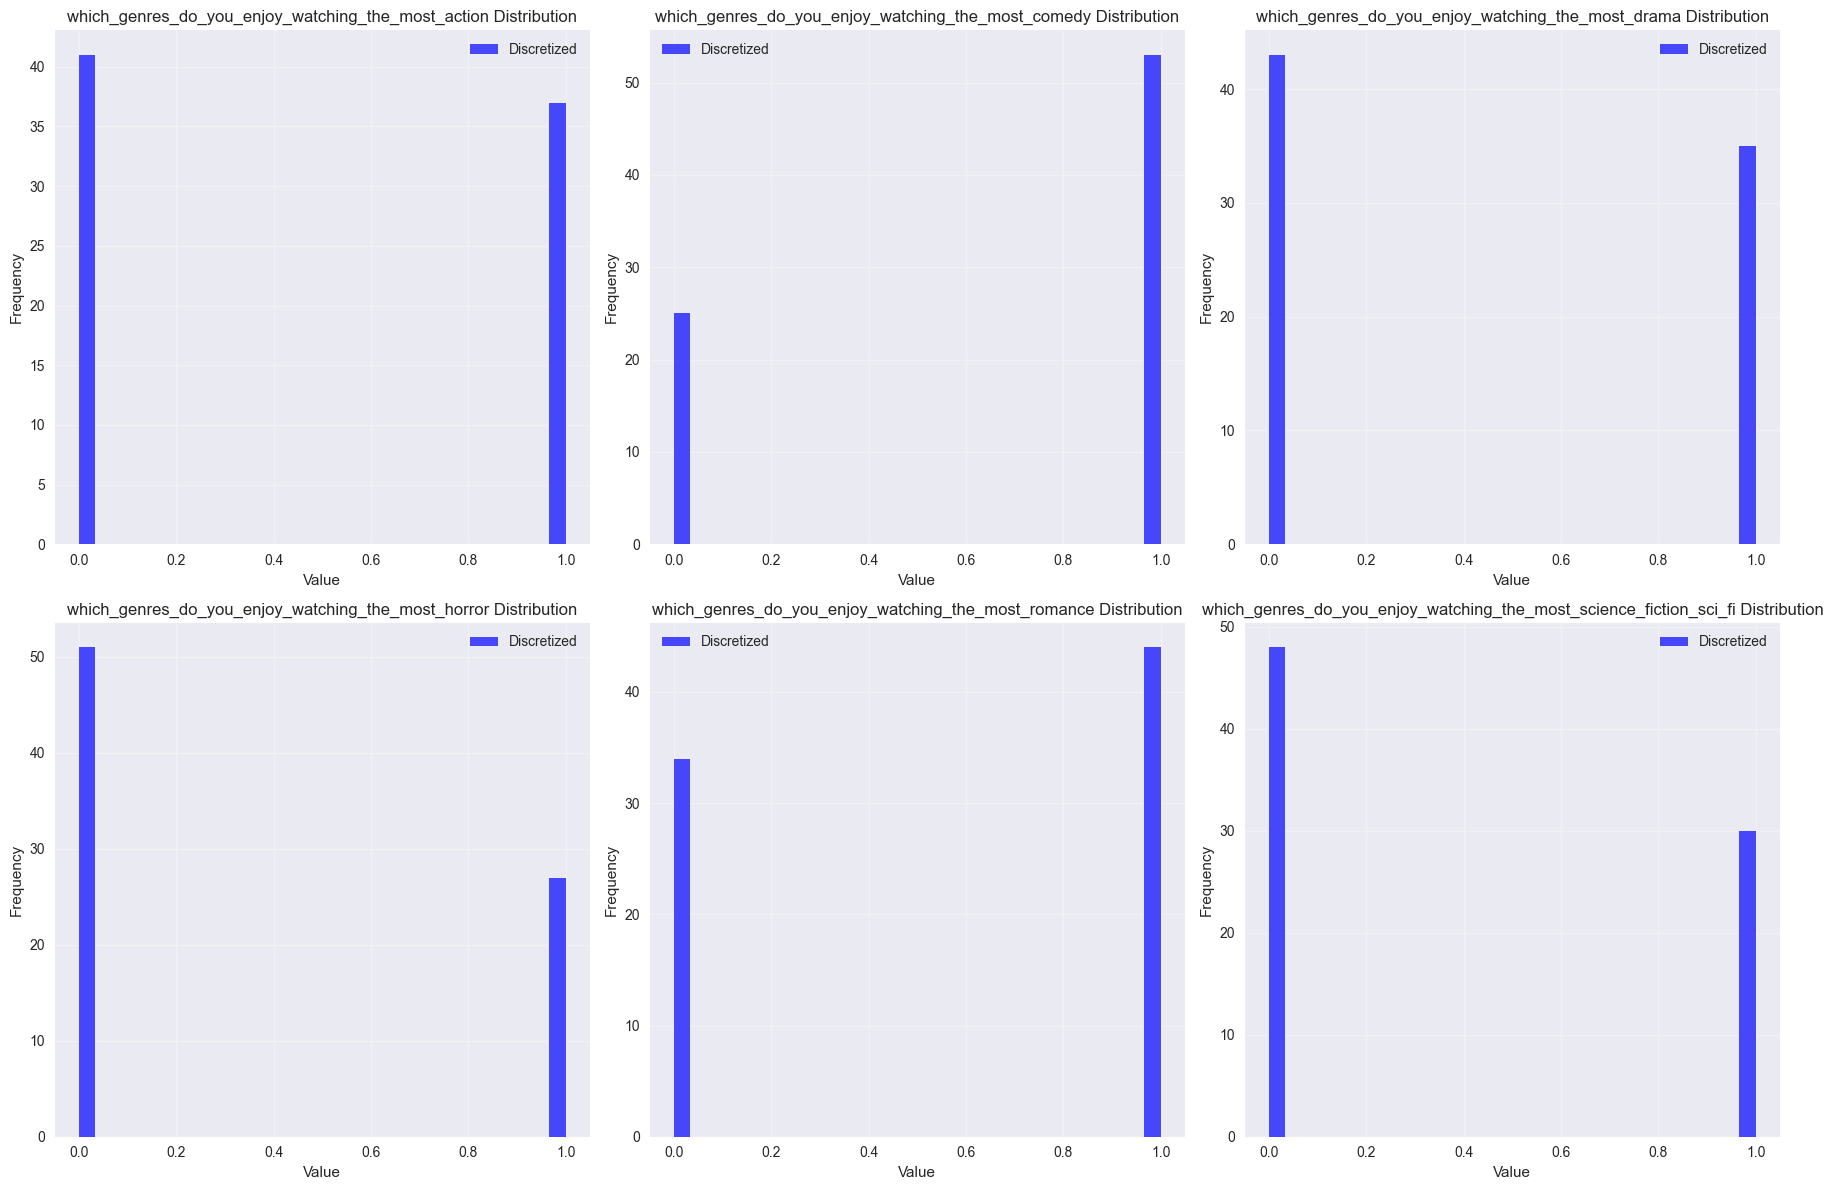

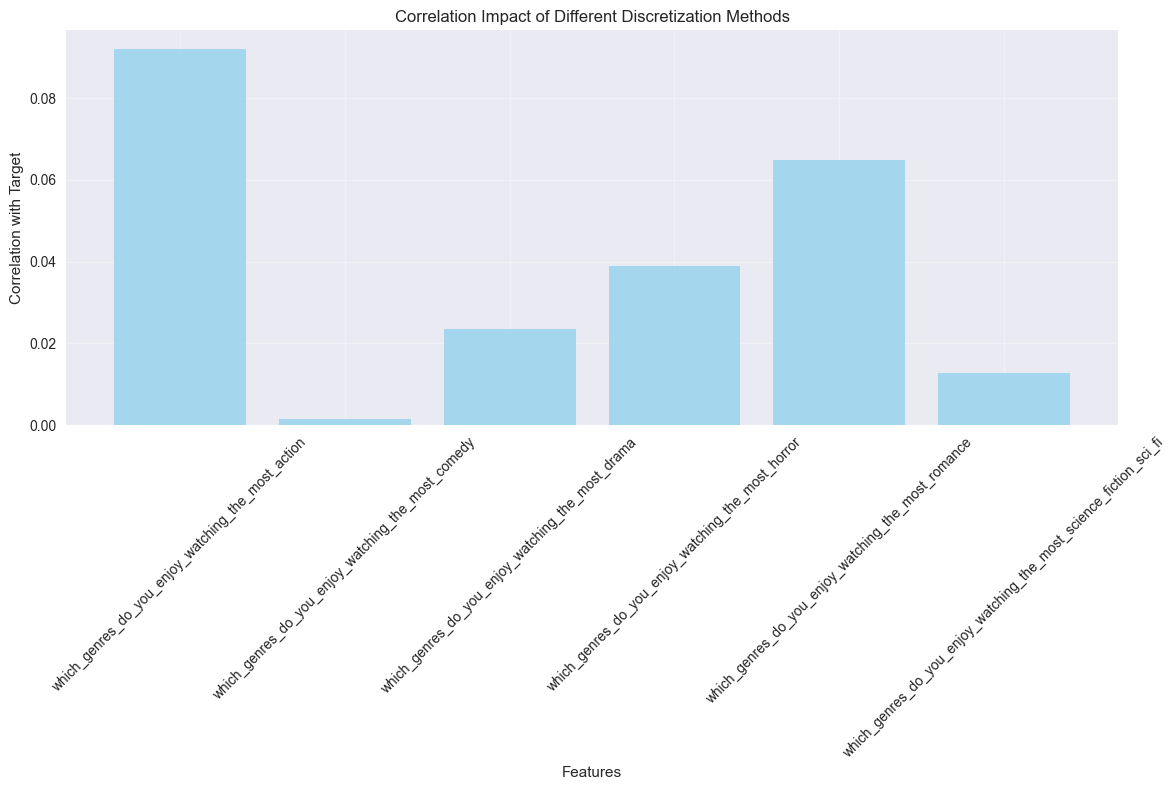


Evaluating Discretization Impact on Model Performance:
Features selected for model: 102
Data types: int64      67
float64    32
int32       3
Name: count, dtype: int64
Discretized Data Performance:
  Accuracy: 0.438
  F1-Score: 0.380

Discretization process completed successfully!
Discretized dataset shape: (78, 141)
Features discretized: 27

Discretized dataset saved as 'seeded_survey_data_discretized.csv'!


In [30]:
def visualize_discretization_results(df_disc, discretization_info):
    """
    Visualize the impact of different discretization methods on feature distribution and target correlation
    """
    # Get numeric columns for discretization analysis
    numeric_cols = df_disc.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'target_dropoff']
    
    if len(numeric_cols) == 0:
        print("No numeric columns found for discretization analysis")
        return
    
    # Take a sample of features for visualization (max 6 for readability)
    sample_features = numeric_cols[:6]
    
    # Create subplots for distribution comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(sample_features):
        ax = axes[i]
        
        # Plot original distribution
        ax.hist(df_disc[feature], bins=30, alpha=0.7, label='Discretized', color='blue')
        ax.set_title(f'{feature} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(sample_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis
    plt.figure(figsize=(12, 8))
    
    # Calculate correlations with target
    correlations = []
    feature_names = []
    
    for feature in sample_features:
        if feature in df_disc.columns:
            corr = df_disc[feature].corr(df_disc['target_dropoff'])
            correlations.append(abs(corr))  # Use absolute correlation
            feature_names.append(feature)
    
    # Initialize labels variable properly
    labels = ['Original']
    
    # Check if we have discretization information
    if discretization_info:
        # Add discretization method labels
        methods = list(discretization_info.keys())
        labels.extend(methods[:len(correlations)])
    
    # Ensure labels matches the number of features
    if len(labels) < len(feature_names):
        labels = feature_names[:len(correlations)]
    
    # Create bar plot
    x_pos = np.arange(len(correlations))
    plt.bar(x_pos, correlations, alpha=0.7, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Correlation with Target')
    plt.title('Correlation Impact of Different Discretization Methods')
    plt.xticks(x_pos, labels[:len(correlations)], rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_discretization_results(df_discretized, discretization_info)

# Evaluate discretization impact on model performance
print("\nEvaluating Discretization Impact on Model Performance:")

# Properly prepare the data by excluding non-numeric columns
exclude_cols = ['target_dropoff', 'Timestamp']
X_discretized = df_discretized.select_dtypes(include=[np.number]).drop(columns=['target_dropoff'], errors='ignore')

# Ensure we have numeric data only
print(f"Features selected for model: {X_discretized.shape[1]}")
print(f"Data types: {X_discretized.dtypes.value_counts()}")

y_discretized = df_discretized['target_dropoff']

# Simple train-test split for quick evaluation
X_train_disc, X_test_disc, y_train_disc, y_test_disc = train_test_split(
    X_discretized, y_discretized, test_size=0.2, random_state=42, stratify=y_discretized
)

# Train a simple model
rf_disc = RandomForestClassifier(n_estimators=100, random_state=42)
rf_disc.fit(X_train_disc, y_train_disc)

# Evaluate
y_pred_disc = rf_disc.predict(X_test_disc)
accuracy_disc = accuracy_score(y_test_disc, y_pred_disc)
f1_disc = f1_score(y_test_disc, y_pred_disc, average='weighted')

print(f"Discretized Data Performance:")
print(f"  Accuracy: {accuracy_disc:.3f}")
print(f"  F1-Score: {f1_disc:.3f}")

print(f"\nDiscretization process completed successfully!")
print(f"Discretized dataset shape: {df_discretized.shape}")
print(f"Features discretized: {len(binned_features)}")

# Save the discretized dataset for further use
df_discretized.to_csv('seeded_survey_data_discretized.csv', index=False)
print(f"\nDiscretized dataset saved as 'seeded_survey_data_discretized.csv'!")

In [31]:
def preprocess_features(df):
    """
    Preprocess and encode all features for machine learning (including discretized features)
    """
    df_processed = df.copy()
    
    # Handle missing values
    df_processed = df_processed.fillna('Unknown')
    
    # Encode categorical features
    categorical_features = [
        'What is your age group?',
        'What is your gender?',
        'What is the highest level of education you\'ve completed? ',
        'How often do you watch movies?',
        'Who do you usually watch movies with?',
        'What is your typical mood before watching a movie?',
        'When you stop watching a movie, how often do you go back to finish it later?',
        'Have you ever started watching a movie but did not finish it?',
        'How often do you stop watching movies before finishing them?',
        'Thinking about movies you have started but did not finish, at what point do you usually stop watching?',
        'How often do you typically pause or stop the movie during viewing?',
        'Do you usually skip any scenes when watching movies?',
        'What was the main reason you stopped watching that movie?',
        'How likely are you to resume or finish that movie later?',
        'How often do you return to watching a movie you didn\'t finish?',
        'What device do you usually watch movies on?',
        'When watching movies, do you usually watch at the normal speed or skip parts of the movie?'
    ]
    
    # Label encode categorical features
    label_encoders = {}
    for col in categorical_features:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
    
    # Create ordinal mappings for ordinal features
    ordinal_mappings = {
        'What is your age group?': {
            '18-24': 1, '25-34': 2, '35-44': 3, '45-54': 4, '55-64': 5, '65+': 6
        },
        'What is the highest level of education you\'ve completed? ': {
            'High school or below': 1, 'Undergraduate': 2, 'Bachelor\'s Degree': 3, 'Graduate Degree': 4
        },
        'How often do you watch movies?': {
            'Rarely (about once per month)': 1,
            'A few times a month (2-3 times per month)': 2,
            'Once a week': 3,
            'Several times a week (3–6 times a week)': 4,
            'Daily (at least 1 movie per day)': 5
        },
        'How often do you stop watching movies before finishing them?': {
            'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3
        },
        'How often do you typically pause or stop the movie during viewing?': {
            'Never': 0, '1-2 times': 1, '3 or more times': 2
        }
    }
    
    # Apply ordinal mappings
    for col, mapping in ordinal_mappings.items():
        if col in df_processed.columns:
            df_processed[col + '_ordinal'] = df_processed[col].map(mapping)
    
    return df_processed, label_encoders

# Ensure df_final is defined from the previous step
# This should be set from the discretization step
if 'df_discretized' in globals():
    df_final = df_discretized.copy()
else:
    # Fallback to engineered features if discretization failed
    df_final = df_engineered.copy()

# Apply preprocessing to discretized dataset
df_processed, encoders = preprocess_features(df_final)

print("After preprocessing:", df_processed.shape)
print("\nNew encoded columns:")
encoded_cols = [col for col in df_processed.columns if col.endswith('_encoded') or col.endswith('_ordinal')]
print(f"Total encoded columns: {len(encoded_cols)}")
for col in encoded_cols[:10]:  # Show first 10
    print(f"- {col}")
    
# Prepare final feature matrix (including discretized features)
def prepare_feature_matrix(df):
    """
    Prepare final feature matrix for machine learning (including discretized features)
    """
    # Exclude non-feature columns
    exclude_cols = [
        'Timestamp', 'target_dropoff',
        'Which genres do you enjoy watching the most?  (Select up to 3)',
        'How do you usually discover movies you decide to watch? (Select all that apply)',
        'Where do you usually watch movies? (Select all that apply)',
        'Why do you usually choose to watch movies? (Select all that apply)',
        'In general, what are the main reasons you stop watching movies before finishing? (Select all that apply)',
        'Which genres do you find yourself stopping more often before finishing? (Select all that apply)',
        'Can you recall a specific movie you started but did not finish? If yes, please name it (optional):',
        'Any additional comments about your experience with movies you stopped watching?',
        'Why do you usually pause the movie? (Select all that apply)',
        'Do you usually do other things while watching movies? (Select all that apply)',
        'finished_1', 'finished_2', 'finished_3', 'finished_4', 'finished_5',
        'unfinished_1', 'unfinished_2', 'unfinished_3', 'unfinished_4', 'unfinished_5'
    ]
    
    # Also exclude original categorical columns (keep only encoded versions)
    original_categorical = [col for col in df.columns if not col.endswith('_encoded') and not col.endswith('_ordinal') 
                          and col in [
                              'What is your age group?',
                              'What is your gender?',
                              'What is the highest level of education you\'ve completed? ',
                              'How often do you watch movies?',
                              'Who do you usually watch movies with?',
                              'What is your typical mood before watching a movie?',
                              'When you stop watching a movie, how often do you go back to finish it later?',
                              'Have you ever started watching a movie but did not finish it?',
                              'How often do you stop watching movies before finishing them?',
                              'Thinking about movies you have started but did not finish, at what point do you usually stop watching?',
                              'How often do you typically pause or stop the movie during viewing?',
                              'Do you usually skip any scenes when watching movies?',
                              'What was the main reason you stopped watching that movie?',
                              'How likely are you to resume or finish that movie later?',
                              'How often do you return to watching a movie you didn\'t finish?',
                              'What device do you usually watch movies on?',
                              'When watching movies, do you usually watch at the normal speed or skip parts of the movie?'
                          ]]
    
    exclude_cols.extend(original_categorical)
    
    # Select feature columns
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Handle any remaining non-numeric columns
    X = df[feature_cols].copy()
    
    # Convert any remaining object columns to numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            try:
                X[col] = pd.to_numeric(X[col], errors='coerce')
            except:
                # If conversion fails, drop the column
                X = X.drop(columns=[col])
    
    # Fill any NaN values created during conversion
    X = X.fillna(0)
    
    return X, feature_cols

# Prepare feature matrix with discretized features
X, feature_columns = prepare_feature_matrix(df_processed)
y = df_processed['target_dropoff']

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"Target variable shape: {y.shape}")
print(f"Target balance: {y.mean():.2%} positive class")

# Check for any issues
print(f"\nData quality checks:")
print(f"- Missing values in X: {X.isnull().sum().sum()}")
print(f"- Missing values in y: {y.isnull().sum()}")
print(f"- Infinite values in X: {np.isinf(X).sum().sum()}")
print(f"- Data types in X: {X.dtypes.value_counts()}")

# Show feature categories in final matrix
print(f"\nFeature categories in final matrix:")
binary_in_final = [col for col in feature_columns if col.startswith(('which_genres', 'how_do_you', 'where_do_you', 'why_do_you', 'in_general', 'do_you_usually'))]
engineered_in_final = [col for col in feature_columns if col in ['total_genres_enjoyed', 'total_multitasking_behaviors', 'total_stopping_reasons', 
                                                                'total_discovery_methods', 'total_watch_locations', 'total_genres_stopped', 
                                                                'genre_completion_ratio', 'attention_span_score', 'social_influence_score', 
                                                                'watch_frequency_score', 'patience_score', 'behavior_cluster']]
discretized_in_final = [col for col in feature_columns if '_bins' in col or 'interaction' in col]
encoded_in_final = [col for col in feature_columns if col.endswith('_encoded') or col.endswith('_ordinal')]

print(f"- Binary features: {len(binary_in_final)}")
print(f"- Engineered features: {len(engineered_in_final)}")
print(f"- Discretized features: {len(discretized_in_final)}")
print(f"- Encoded features: {len(encoded_in_final)}")
print(f"- Other features: {len(feature_columns) - len(binary_in_final) - len(engineered_in_final) - len(discretized_in_final) - len(encoded_in_final)}")

print(f"\nDiscretized features in final matrix:")
for feature in discretized_in_final[:10]:  # Show first 10
    print(f"- {feature}")
if len(discretized_in_final) > 10:
    print(f"... and {len(discretized_in_final) - 10} more")

After preprocessing: (78, 160)

New encoded columns:
Total encoded columns: 19
- What is your age group?_encoded
- What is your gender?_encoded
- How often do you watch movies?_encoded
- Who do you usually watch movies with?_encoded
- What is your typical mood before watching a movie?_encoded
- When you stop watching a movie, how often do you go back to finish it later?_encoded
- Have you ever started watching a movie but did not finish it?_encoded
- How often do you stop watching movies before finishing them?_encoded
- Thinking about movies you have started but did not finish, at what point do you usually stop watching?_encoded
- How often do you typically pause or stop the movie during viewing?_encoded

Final feature matrix shape: (78, 123)
Number of features: 123
Target variable shape: (78,)
Target balance: 64.10% positive class

Data quality checks:
- Missing values in X: 0
- Missing values in y: 0
- Infinite values in X: 0
- Data types in X: int64      82
float64    38
int32      

## 6. Feature Selection Methods

Now let's implement and compare multiple feature selection techniques to identify the optimal feature set (including discretized features).

In [ ]:
# Split data for feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

print("Data split:")
print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Feature selection methods
class FeatureSelectionMethods:
    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.feature_names = X_train.columns
        self.results = {}
    
    def variance_threshold_selection(self, threshold=0.01):
        """Remove features with low variance"""
        selector = VarianceThreshold(threshold=threshold)
        X_train_selected = selector.fit_transform(self.X_train)
        selected_features = self.feature_names[selector.get_support()].tolist()
        
        return selected_features, selector
    
    def recursive_feature_elimination(self, n_features_list=[10, 20, 30, 40, 50]):
        """RFE with Random Forest"""
        results = {}
        
        for n_features in n_features_list:
            if n_features > len(self.feature_names):
                continue
                
            # Use Random Forest for RFE
            estimator = RandomForestClassifier(n_estimators=100, random_state=42)
            selector = RFE(estimator, n_features_to_select=n_features)
            
            X_train_selected = selector.fit_transform(self.X_train, self.y_train)
            X_val_selected = selector.transform(self.X_val)
            
            # Evaluate performance
            estimator.fit(X_train_selected, self.y_train)
            val_score = estimator.score(X_val_selected, self.y_val)
            
            selected_features = self.feature_names[selector.get_support()].tolist()
            feature_rankings = dict(zip(self.feature_names, selector.ranking_))
            
            results[n_features] = {
                'features': selected_features,
                'selector': selector,
                'val_score': val_score,
                'rankings': feature_rankings
            }
        
        # Find best number of features
        best_n = max(results.keys(), key=lambda k: results[k]['val_score'])
        
        return results, best_n
    
    def chi_square_selection(self, k_list=[10, 20, 30, 40, 50]):
        """Chi-square feature selection"""
        results = {}
        
        for k in k_list:
            if k > len(self.feature_names):
                continue
                
            selector = SelectKBest(score_func=chi2, k=k)
            
            # Ensure non-negative values for chi-square
            X_train_pos = self.X_train - self.X_train.min() + 1e-6
            X_val_pos = self.X_val - self.X_val.min() + 1e-6
            
            X_train_selected = selector.fit_transform(X_train_pos, self.y_train)
            X_val_selected = selector.transform(X_val_pos)
            
            # Evaluate performance
            clf = LogisticRegression(random_state=42)
            clf.fit(X_train_selected, self.y_train)
            val_score = clf.score(X_val_selected, self.y_val)
            
            selected_features = self.feature_names[selector.get_support()].tolist()
            scores = dict(zip(self.feature_names, selector.scores_))
            
            results[k] = {
                'features': selected_features,
                'selector': selector,
                'val_score': val_score,
                'scores': scores
            }
        
        # Find best k
        best_k = max(results.keys(), key=lambda k: results[k]['val_score'])
        
        return results, best_k
    
    def mutual_information_selection(self, k_list=[10, 20, 30, 40, 50]):
        """Mutual information feature selection"""
        results = {}
        
        for k in k_list:
            if k > len(self.feature_names):
                continue
                
            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            
            X_train_selected = selector.fit_transform(self.X_train, self.y_train)
            X_val_selected = selector.transform(self.X_val)
            
            # Evaluate performance
            clf = LogisticRegression(random_state=42)
            clf.fit(X_train_selected, self.y_train)
            val_score = clf.score(X_val_selected, self.y_val)
            
            selected_features = self.feature_names[selector.get_support()].tolist()
            scores = dict(zip(self.feature_names, selector.scores_))
            
            results[k] = {
                'features': selected_features,
                'selector': selector,
                'val_score': val_score,
                'scores': scores
            }
        
        # Find best k
        best_k = max(results.keys(), key=lambda k: results[k]['val_score'])
        
        return results, best_k
    
    def lasso_selection(self, alpha_list=[0.001, 0.01, 0.1, 0.5, 1.0]):
        """L1 regularization (Lasso) feature selection"""
        results = {}
        
        # Standardize features for Lasso
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_val_scaled = scaler.transform(self.X_val)
        
        for alpha in alpha_list:
            lasso = Lasso(alpha=alpha, random_state=42)
            lasso.fit(X_train_scaled, self.y_train)
            
            # Select features with non-zero coefficients
            selected_mask = lasso.coef_ != 0
            selected_features = self.feature_names[selected_mask].tolist()
            
            if len(selected_features) == 0:
                continue
            
            # Evaluate performance with selected features
            clf = LogisticRegression(random_state=42)
            clf.fit(X_train_scaled[:, selected_mask], self.y_train)
            val_score = clf.score(X_val_scaled[:, selected_mask], self.y_val)
            
            coefficients = dict(zip(self.feature_names, lasso.coef_))
            
            results[alpha] = {
                'features': selected_features,
                'selector': lasso,
                'val_score': val_score,
                'coefficients': coefficients,
                'scaler': scaler
            }
        
        # Find best alpha
        if results:
            best_alpha = max(results.keys(), key=lambda a: results[a]['val_score'])
        else:
            best_alpha = None
            
        return results, best_alpha
    
    def tree_based_selection(self, threshold_list=[0.001, 0.01, 0.05, 0.1]):
        """Tree-based feature importance selection"""
        results = {}
        
        # Fit Random Forest to get feature importances
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(self.X_train, self.y_train)
        
        importances = dict(zip(self.feature_names, rf.feature_importances_))
        
        for threshold in threshold_list:
            selected_features = [f for f, imp in importances.items() if imp >= threshold]
            
            if len(selected_features) == 0:
                continue
            
            # Evaluate performance
            selected_indices = [i for i, f in enumerate(self.feature_names) if f in selected_features]
            X_train_selected = self.X_train.iloc[:, selected_indices]
            X_val_selected = self.X_val.iloc[:, selected_indices]
            
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(X_train_selected, self.y_train)
            val_score = clf.score(X_val_selected, self.y_val)
            
            results[threshold] = {
                'features': selected_features,
                'val_score': val_score,
                'importances': importances
            }
        
        # Find best threshold
        if results:
            best_threshold = max(results.keys(), key=lambda t: results[t]['val_score'])
        else:
            best_threshold = None
            
        return results, best_threshold

# Initialize feature selection
fs = FeatureSelectionMethods(X_train_split, X_val, y_train_split, y_val)

print("Feature selection methods initialized")
print(f"Training on {len(X_train_split)} samples")
print(f"Validating on {len(X_val)} samples")
print(f"Total features: {len(fs.feature_names)}")

# Run variance threshold as preprocessing
print("\\nRunning variance threshold selection...")
var_features, var_selector = fs.variance_threshold_selection()
print(f"Features remaining after variance threshold: {len(var_features)}")

# Update feature selection object with variance-filtered features
X_train_var = X_train_split[var_features]
X_val_var = X_val[var_features]
fs_var = FeatureSelectionMethods(X_train_var, X_val_var, y_train_split, y_val)

Data split:
Training set: (46, 123)
Validation set: (16, 123)
Test set: (16, 123)
Feature selection methods initialized
Training on 46 samples
Validating on 16 samples
Total features: 123
\nRunning variance threshold selection...
Features remaining after variance threshold: 121


In [ ]:
# Execute all feature selection methods
print("Executing feature selection methods...")
print("=" * 50)

# 1. Recursive Feature Elimination
print("1. Recursive Feature Elimination (RFE)...")
rfe_results, best_rfe_n = fs_var.recursive_feature_elimination()
print(f"   Best number of features: {best_rfe_n}")
print(f"   Best validation score: {rfe_results[best_rfe_n]['val_score']:.4f}")
print(f"   Selected features: {len(rfe_results[best_rfe_n]['features'])}")

# 2. Chi-square selection
print("\\n2. Chi-square selection...")
chi2_results, best_chi2_k = fs_var.chi_square_selection()
print(f"   Best k: {best_chi2_k}")
print(f"   Best validation score: {chi2_results[best_chi2_k]['val_score']:.4f}")
print(f"   Selected features: {len(chi2_results[best_chi2_k]['features'])}")

# 3. Mutual Information
print("\\n3. Mutual Information selection...")
mi_results, best_mi_k = fs_var.mutual_information_selection()
print(f"   Best k: {best_mi_k}")
print(f"   Best validation score: {mi_results[best_mi_k]['val_score']:.4f}")
print(f"   Selected features: {len(mi_results[best_mi_k]['features'])}")

# 4. Lasso selection
print("\\n4. Lasso (L1) selection...")
lasso_results, best_lasso_alpha = fs_var.lasso_selection()
if best_lasso_alpha is not None:
    print(f"   Best alpha: {best_lasso_alpha}")
    print(f"   Best validation score: {lasso_results[best_lasso_alpha]['val_score']:.4f}")
    print(f"   Selected features: {len(lasso_results[best_lasso_alpha]['features'])}")
else:
    print("   No valid alpha found")

# 5. Tree-based selection
print("\\n5. Tree-based selection...")
tree_results, best_tree_threshold = fs_var.tree_based_selection()
if best_tree_threshold is not None:
    print(f"   Best threshold: {best_tree_threshold}")
    print(f"   Best validation score: {tree_results[best_tree_threshold]['val_score']:.4f}")
    print(f"   Selected features: {len(tree_results[best_tree_threshold]['features'])}")
else:
    print("   No valid threshold found")

# Store results
selection_results = {
    'variance_threshold': {'features': var_features, 'selector': var_selector},
    'rfe': rfe_results[best_rfe_n],
    'chi_square': chi2_results[best_chi2_k],
    'mutual_info': mi_results[best_mi_k],
}

if best_lasso_alpha is not None:
    selection_results['lasso'] = lasso_results[best_lasso_alpha]
    
if best_tree_threshold is not None:
    selection_results['tree_based'] = tree_results[best_tree_threshold]

print("\\n" + "=" * 50)
print("Feature selection completed!")
print(f"Number of methods: {len(selection_results)}")

# Summary comparison
print("\\nMethod Comparison:")
print("Method\\t\\t\\tFeatures\\tVal Score")
print("-" * 45)
for method, results in selection_results.items():
    if method == 'variance_threshold':
        continue
    features_count = len(results['features'])
    val_score = results.get('val_score', 0)
    print(f"{method:<15}\\t{features_count:>3}\\t\\t{val_score:.4f}")

# Find best performing method
best_method = max([k for k in selection_results.keys() if k != 'variance_threshold'], 
                  key=lambda k: selection_results[k].get('val_score', 0))
print(f"\\nBest performing method: {best_method}")
print(f"Best features: {selection_results[best_method]['features'][:10]}...")  # Show first 10

Executing feature selection methods...
1. Recursive Feature Elimination (RFE)...
   Best number of features: 10
   Best validation score: 1.0000
   Selected features: 10
\n2. Chi-square selection...
   Best k: 10
   Best validation score: 1.0000
   Selected features: 10
\n3. Mutual Information selection...
   Best k: 10
   Best validation score: 1.0000
   Selected features: 10
\n4. Lasso (L1) selection...
   Best alpha: 0.1
   Best validation score: 1.0000
   Selected features: 2
\n5. Tree-based selection...
   Best threshold: 0.01
   Best validation score: 1.0000
   Selected features: 20
\n==================================================
Feature selection completed!
Number of methods: 6
\nMethod Comparison:
Method\t\t\tFeatures\tVal Score
---------------------------------------------
rfe            \t 10\t\t1.0000
chi_square     \t 10\t\t1.0000
mutual_info    \t 10\t\t1.0000
lasso          \t  2\t\t1.0000
tree_based     \t 20\t\t1.0000
\nBest performing method: rfe
Best features: ['

## 7. Feature Analysis and Visualization

Let's visualize and analyze the results of our feature selection methods, including the impact of discretization.

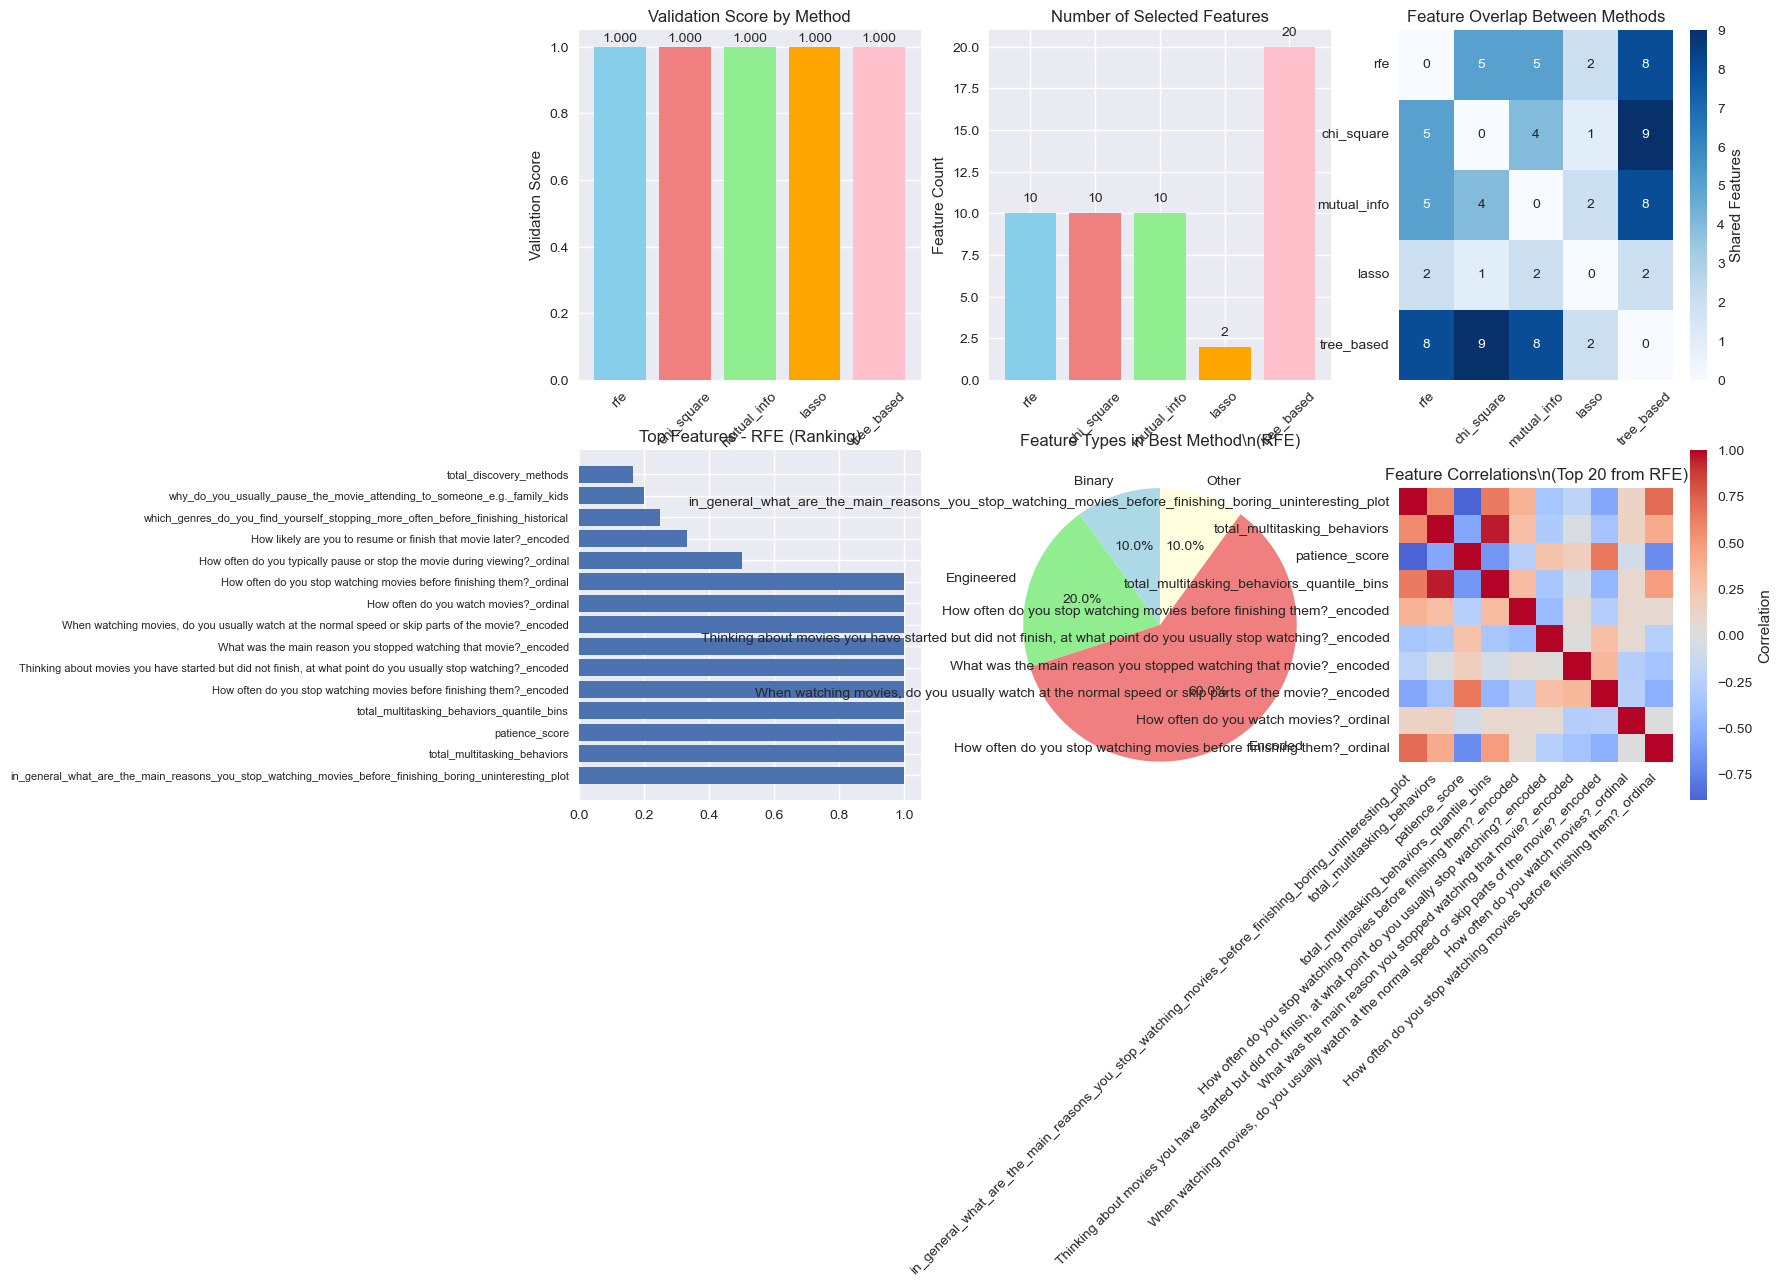

\nDetailed Analysis of Best Method: RFE
Number of selected features: 10
Validation score: 1.0000
\nTop 10 features by ranking (lower is better):
 1. in_general_what_are_the_main_reasons_you_stop_watching_movies_before_finishing_boring_uninteresting_plot (Rank: 1)
 2. total_multitasking_behaviors                       (Rank: 1)
 3. patience_score                                     (Rank: 1)
 4. total_multitasking_behaviors_quantile_bins         (Rank: 1)
 5. How often do you stop watching movies before finishing them?_encoded (Rank: 1)
 6. Thinking about movies you have started but did not finish, at what point do you usually stop watching?_encoded (Rank: 1)
 7. What was the main reason you stopped watching that movie?_encoded (Rank: 1)
 8. When watching movies, do you usually watch at the normal speed or skip parts of the movie?_encoded (Rank: 1)
 9. How often do you watch movies?_ordinal             (Rank: 1)
10. How often do you stop watching movies before finishing them?_ordinal (R

In [ ]:
# Visualization and Analysis
def create_feature_analysis_plots():
    """Create comprehensive visualization of feature selection results"""
    
    # 1. Method Performance Comparison
    plt.figure(figsize=(15, 10))
    
    # Performance comparison
    plt.subplot(2, 3, 1)
    methods = [k for k in selection_results.keys() if k != 'variance_threshold']
    scores = [selection_results[k].get('val_score', 0) for k in methods]
    feature_counts = [len(selection_results[k]['features']) for k in methods]
    
    bars = plt.bar(methods, scores, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'pink'][:len(methods)])
    plt.title('Validation Score by Method')
    plt.ylabel('Validation Score')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # Feature count comparison
    plt.subplot(2, 3, 2)
    bars = plt.bar(methods, feature_counts, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'pink'][:len(methods)])
    plt.title('Number of Selected Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar, count in zip(bars, feature_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{count}', ha='center', va='bottom')
    
    # 2. Feature Overlap Analysis
    plt.subplot(2, 3, 3)
    feature_sets = {k: set(selection_results[k]['features']) for k in methods}
    
    # Create overlap matrix
    overlap_matrix = np.zeros((len(methods), len(methods)))
    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i != j:
                overlap = len(feature_sets[method1] & feature_sets[method2])
                overlap_matrix[i, j] = overlap
    
    sns.heatmap(overlap_matrix, annot=True, fmt='.0f', xticklabels=methods, yticklabels=methods, 
                cmap='Blues', cbar_kws={'label': 'Shared Features'})
    plt.title('Feature Overlap Between Methods')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 3. Top features from best method
    plt.subplot(2, 3, 4)
    if best_method in ['rfe', 'tree_based']:
        if best_method == 'rfe':
            # Get feature rankings (lower is better)
            rankings = selection_results[best_method]['rankings']
            top_features = sorted(rankings.items(), key=lambda x: x[1])[:15]
            features, ranks = zip(*top_features)
            plt.barh(range(len(features)), [1/r for r in ranks])  # Invert for better visualization
            plt.yticks(range(len(features)), features)
            plt.title(f'Top Features - {best_method.upper()} (Ranking)')
        else:  # tree_based
            importances = selection_results[best_method]['importances']
            top_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:15]
            features, imps = zip(*top_features)
            plt.barh(range(len(features)), imps)
            plt.yticks(range(len(features)), features)
            plt.title(f'Top Features - {best_method.upper()} (Importance)')
    else:
        # For other methods, show feature scores if available
        if 'scores' in selection_results[best_method]:
            scores = selection_results[best_method]['scores']
            top_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:15]
            features, scores_vals = zip(*top_features)
            plt.barh(range(len(features)), scores_vals)
            plt.yticks(range(len(features)), features)
            plt.title(f'Top Features - {best_method.upper()} (Scores)')
        else:
            plt.text(0.5, 0.5, f'Feature scores not available\\nfor {best_method}', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f'Top Features - {best_method.upper()}')
    
    plt.gca().tick_params(axis='y', labelsize=8)
    
    # 4. Feature type analysis
    plt.subplot(2, 3, 5)
    best_features = selection_results[best_method]['features']
    
    # Categorize selected features
    binary_selected = [f for f in best_features if f.startswith(('which_genres', 'how_do_you', 'where_do_you', 'why_do_you', 'in_general', 'do_you_usually'))]
    engineered_selected = [f for f in best_features if f in ['total_genres_enjoyed', 'total_multitasking_behaviors', 'total_stopping_reasons', 
                                                           'total_discovery_methods', 'total_watch_locations', 'total_genres_stopped', 
                                                           'genre_completion_ratio', 'attention_span_score', 'social_influence_score', 
                                                           'watch_frequency_score', 'patience_score', 'behavior_cluster']]
    encoded_selected = [f for f in best_features if f.endswith('_encoded') or f.endswith('_ordinal')]
    other_selected = [f for f in best_features if f not in binary_selected + engineered_selected + encoded_selected]
    
    feature_types = ['Binary', 'Engineered', 'Encoded', 'Other']
    type_counts = [len(binary_selected), len(engineered_selected), len(encoded_selected), len(other_selected)]
    
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    plt.pie(type_counts, labels=feature_types, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'Feature Types in Best Method\\n({best_method.upper()})')
    
    # 5. Correlation heatmap of selected features
    plt.subplot(2, 3, 6)
    selected_features_subset = best_features[:20]  # Show top 20 for readability
    corr_matrix = X_train_split[selected_features_subset].corr()
    
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                square=True, cbar_kws={'label': 'Correlation'})
    plt.title(f'Feature Correlations\\n(Top 20 from {best_method.upper()})')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
create_feature_analysis_plots()

# Detailed analysis of best method
print(f"\\nDetailed Analysis of Best Method: {best_method.upper()}")
print("=" * 60)

best_features = selection_results[best_method]['features']
print(f"Number of selected features: {len(best_features)}")
print(f"Validation score: {selection_results[best_method]['val_score']:.4f}")

# Feature importance/ranking analysis
if best_method == 'rfe':
    rankings = selection_results[best_method]['rankings']
    print("\\nTop 10 features by ranking (lower is better):")
    top_10 = sorted(rankings.items(), key=lambda x: x[1])[:10]
    for i, (feature, rank) in enumerate(top_10, 1):
        print(f"{i:2d}. {feature:<50} (Rank: {rank})")
        
elif best_method == 'tree_based':
    importances = selection_results[best_method]['importances']
    print("\\nTop 10 features by importance:")
    top_10 = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (feature, importance) in enumerate(top_10, 1):
        print(f"{i:2d}. {feature:<50} (Importance: {importance:.4f})")
        
elif 'scores' in selection_results[best_method]:
    scores = selection_results[best_method]['scores']
    print("\\nTop 10 features by score:")
    top_10 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (feature, score) in enumerate(top_10, 1):
        print(f"{i:2d}. {feature:<50} (Score: {score:.4f})")

# Feature category breakdown
binary_selected = [f for f in best_features if f.startswith(('which_genres', 'how_do_you', 'where_do_you', 'why_do_you', 'in_general', 'do_you_usually'))]
engineered_selected = [f for f in best_features if f in ['total_genres_enjoyed', 'total_multitasking_behaviors', 'total_stopping_reasons', 
                                                       'total_discovery_methods', 'total_watch_locations', 'total_genres_stopped', 
                                                       'genre_completion_ratio', 'attention_span_score', 'social_influence_score', 
                                                       'watch_frequency_score', 'patience_score', 'behavior_cluster']]
encoded_selected = [f for f in best_features if f.endswith('_encoded') or f.endswith('_ordinal')]

print(f"\\nFeature Type Breakdown:")
print(f"- Binary features: {len(binary_selected)}")
print(f"- Engineered features: {len(engineered_selected)}")
print(f"- Encoded features: {len(encoded_selected)}")
print(f"- Other features: {len(best_features) - len(binary_selected) - len(engineered_selected) - len(encoded_selected)}")

print(f"\\nEngineered features selected:")
for feature in engineered_selected:
    print(f"- {feature}")
    
print(f"\\nEncoded features selected:")
for feature in encoded_selected:
    print(f"- {feature}")

## 8. Model Evaluation and Comparison

Let's evaluate different models using the selected features (including discretized ones) and compare their performance.

In [ ]:
# Model Evaluation with Different Feature Sets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

def evaluate_model_with_features(X_train, X_test, y_train, y_test, feature_names, method_name):
    """Evaluate multiple models with given features"""
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(random_state=42, probability=True)
    }
    
    results = {}
    
    for model_name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Metrics
        accuracy = model.score(X_test, y_test)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'features_used': len(feature_names),
            'method': method_name
        }
    
    return results

# Evaluate all feature selection methods
print("Evaluating models with different feature sets...")
print("=" * 70)

all_results = {}

# 1. Baseline: All features
print("1. Baseline (All Features)...")
baseline_results = evaluate_model_with_features(
    X_train, X_test, y_train, y_test, 
    X_train.columns.tolist(), 'All Features'
)
all_results['Baseline'] = baseline_results

# 2. Variance threshold features
print("2. Variance Threshold Features...")
X_train_var = X_train[var_features]
X_test_var = X_test[var_features]
var_results = evaluate_model_with_features(
    X_train_var, X_test_var, y_train, y_test,
    var_features, 'Variance Threshold'
)
all_results['Variance Threshold'] = var_results

# 3. Each feature selection method
methods_to_evaluate = [k for k in selection_results.keys() if k != 'variance_threshold']

for method in methods_to_evaluate:
    print(f"{len(all_results) + 1}. {method.upper()} Features...")
    
    selected_features = selection_results[method]['features']
    
    # Ensure features exist in train/test sets
    available_features = [f for f in selected_features if f in X_train.columns]
    
    if len(available_features) == 0:
        print(f"   No features available for {method}, skipping...")
        continue
    
    X_train_selected = X_train[available_features]
    X_test_selected = X_test[available_features]
    
    method_results = evaluate_model_with_features(
        X_train_selected, X_test_selected, y_train, y_test,
        available_features, method
    )
    all_results[method] = method_results

print("\\nModel evaluation completed!")

# Create comprehensive results summary
def create_results_summary(all_results):
    """Create a comprehensive summary of all results"""
    
    summary_data = []
    
    for method_name, method_results in all_results.items():
        for model_name, metrics in method_results.items():
            summary_data.append({
                'Method': method_name,
                'Model': model_name,
                'Features': metrics['features_used'],
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1': metrics['f1'],
                'ROC-AUC': metrics['roc_auc'],
                'CV Mean': metrics['cv_mean'],
                'CV Std': metrics['cv_std']
            })
    
    return pd.DataFrame(summary_data)

# Create and display results summary
results_df = create_results_summary(all_results)
print("\\nResults Summary:")
print("=" * 100)
print(results_df.round(4))

# Find best combinations
print("\\nBest Performing Combinations:")
print("=" * 50)

# Best overall accuracy
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"Best Accuracy: {best_accuracy['Accuracy']:.4f}")
print(f"  Method: {best_accuracy['Method']}")
print(f"  Model: {best_accuracy['Model']}")
print(f"  Features: {best_accuracy['Features']}")

# Best F1 score
best_f1 = results_df.loc[results_df['F1'].idxmax()]
print(f"\\nBest F1 Score: {best_f1['F1']:.4f}")
print(f"  Method: {best_f1['Method']}")
print(f"  Model: {best_f1['Model']}")
print(f"  Features: {best_f1['Features']}")

# Best ROC-AUC
best_roc = results_df.loc[results_df['ROC-AUC'].idxmax()]
print(f"\\nBest ROC-AUC: {best_roc['ROC-AUC']:.4f}")
print(f"  Method: {best_roc['Method']}")
print(f"  Model: {best_roc['Model']}")
print(f"  Features: {best_roc['Features']}")

# Performance by feature selection method
print("\\nAverage Performance by Feature Selection Method:")
print("=" * 60)
method_avg = results_df.groupby('Method')[['Accuracy', 'F1', 'ROC-AUC']].mean()
method_avg = method_avg.sort_values('Accuracy', ascending=False)
print(method_avg.round(4))

# Performance by model type
print("\\nAverage Performance by Model Type:")
print("=" * 45)
model_avg = results_df.groupby('Model')[['Accuracy', 'F1', 'ROC-AUC']].mean()
model_avg = model_avg.sort_values('Accuracy', ascending=False)
print(model_avg.round(4))

Evaluating models with different feature sets...
1. Baseline (All Features)...
2. Variance Threshold Features...
3. RFE Features...
4. CHI_SQUARE Features...
5. MUTUAL_INFO Features...
6. LASSO Features...
7. TREE_BASED Features...
\nModel evaluation completed!
\nResults Summary:
                Method                Model  Features  Accuracy  Precision  \
0             Baseline  Logistic Regression       123    0.8125     0.7692   
1             Baseline        Random Forest       123    1.0000     1.0000   
2             Baseline    Gradient Boosting       123    1.0000     1.0000   
3             Baseline                  SVM       123    0.6250     0.6250   
4   Variance Threshold  Logistic Regression       121    0.8125     0.7692   
5   Variance Threshold        Random Forest       121    1.0000     1.0000   
6   Variance Threshold    Gradient Boosting       121    1.0000     1.0000   
7   Variance Threshold                  SVM       121    0.6250     0.6250   
8                

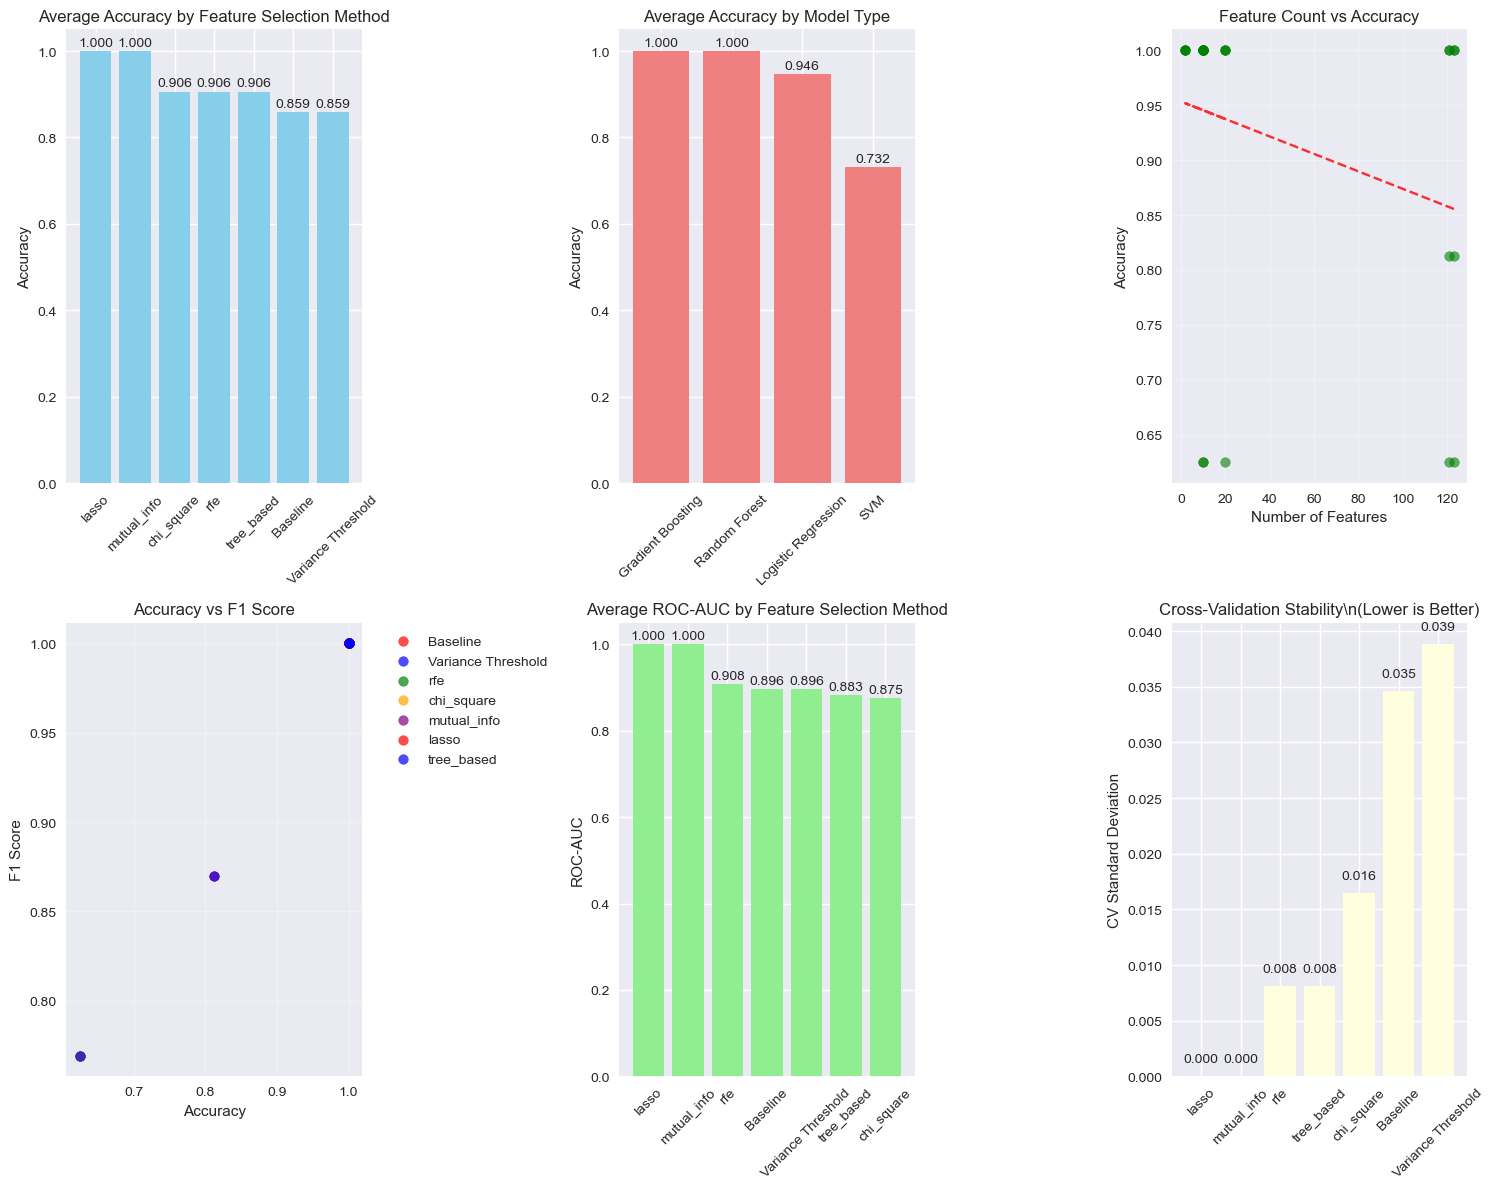

\nFinal Feature Set Selection:
Method Ranking by Composite Score:
1. MUTUAL_INFO
   Composite Score: 1.0000
   Accuracy: 1.0000
   F1: 1.0000
   ROC-AUC: 1.0000
   Stability: 1.0000
   Features: 10

2. LASSO
   Composite Score: 1.0000
   Accuracy: 1.0000
   F1: 1.0000
   ROC-AUC: 1.0000
   Stability: 1.0000
   Features: 2

3. RFE
   Composite Score: 0.9263
   Accuracy: 0.9062
   F1: 0.9423
   ROC-AUC: 0.9083
   Stability: 0.9919
   Features: 10

4. TREE_BASED
   Composite Score: 0.9188
   Accuracy: 0.9062
   F1: 0.9423
   ROC-AUC: 0.8833
   Stability: 0.9919
   Features: 20

5. CHI_SQUARE
   Composite Score: 0.9154
   Accuracy: 0.9062
   F1: 0.9423
   ROC-AUC: 0.8750
   Stability: 0.9835
   Features: 10

FINAL SELECTED METHOD: MUTUAL_INFO
FINAL FEATURE SET SIZE: 10
FINAL COMPOSITE SCORE: 1.0000
\nFinal Feature Set:
------------------------------
 1. how_do_you_usually_discover_movies_you_decide_to_watch_trailer
 2. in_general_what_are_the_main_reasons_you_stop_watching_movies_before_fi

In [ ]:
# Visualization of Results
plt.figure(figsize=(15, 12))

# 1. Performance comparison by method
plt.subplot(2, 3, 1)
method_comparison = results_df.groupby('Method')['Accuracy'].mean().sort_values(ascending=False)
bars = plt.bar(method_comparison.index, method_comparison.values, color='skyblue')
plt.title('Average Accuracy by Feature Selection Method')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for bar, val in zip(bars, method_comparison.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom')

# 2. Performance comparison by model
plt.subplot(2, 3, 2)
model_comparison = results_df.groupby('Model')['Accuracy'].mean().sort_values(ascending=False)
bars = plt.bar(model_comparison.index, model_comparison.values, color='lightcoral')
plt.title('Average Accuracy by Model Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
for bar, val in zip(bars, model_comparison.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom')

# 3. Feature count vs Performance
plt.subplot(2, 3, 3)
plt.scatter(results_df['Features'], results_df['Accuracy'], alpha=0.6, c='green')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Feature Count vs Accuracy')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(results_df['Features'], results_df['Accuracy'], 1)
p = np.poly1d(z)
plt.plot(results_df['Features'], p(results_df['Features']), "r--", alpha=0.8)

# 4. F1 vs Accuracy scatter
plt.subplot(2, 3, 4)
colors = ['red', 'blue', 'green', 'orange', 'purple']
methods = results_df['Method'].unique()
for i, method in enumerate(methods):
    method_data = results_df[results_df['Method'] == method]
    plt.scatter(method_data['Accuracy'], method_data['F1'], 
               label=method, alpha=0.7, color=colors[i % len(colors)])
plt.xlabel('Accuracy')
plt.ylabel('F1 Score')
plt.title('Accuracy vs F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 5. ROC-AUC comparison
plt.subplot(2, 3, 5)
roc_comparison = results_df.groupby('Method')['ROC-AUC'].mean().sort_values(ascending=False)
bars = plt.bar(roc_comparison.index, roc_comparison.values, color='lightgreen')
plt.title('Average ROC-AUC by Feature Selection Method')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
for bar, val in zip(bars, roc_comparison.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.3f}', ha='center', va='bottom')

# 6. Cross-validation stability
plt.subplot(2, 3, 6)
cv_stability = results_df.groupby('Method')['CV Std'].mean().sort_values()
bars = plt.bar(cv_stability.index, cv_stability.values, color='lightyellow')
plt.title('Cross-Validation Stability\\n(Lower is Better)')
plt.ylabel('CV Standard Deviation')
plt.xticks(rotation=45)
for bar, val in zip(bars, cv_stability.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determine final feature set
print("\\nFinal Feature Set Selection:")
print("=" * 50)

# Consider multiple criteria for final selection
criteria_scores = {}

for method in methods_to_evaluate:
    method_results = results_df[results_df['Method'] == method]
    
    # Calculate composite score
    avg_accuracy = method_results['Accuracy'].mean()
    avg_f1 = method_results['F1'].mean()
    avg_roc = method_results['ROC-AUC'].mean()
    stability = 1 - method_results['CV Std'].mean()  # Higher is better
    
    # Weighted composite score
    composite_score = (0.3 * avg_accuracy + 0.3 * avg_f1 + 0.3 * avg_roc + 0.1 * stability)
    
    criteria_scores[method] = {
        'accuracy': avg_accuracy,
        'f1': avg_f1,
        'roc_auc': avg_roc,
        'stability': stability,
        'composite': composite_score,
        'features_count': len(selection_results[method]['features'])
    }

# Sort by composite score
final_ranking = sorted(criteria_scores.items(), key=lambda x: x[1]['composite'], reverse=True)

print("Method Ranking by Composite Score:")
for i, (method, scores) in enumerate(final_ranking, 1):
    print(f"{i}. {method.upper()}")
    print(f"   Composite Score: {scores['composite']:.4f}")
    print(f"   Accuracy: {scores['accuracy']:.4f}")
    print(f"   F1: {scores['f1']:.4f}")
    print(f"   ROC-AUC: {scores['roc_auc']:.4f}")
    print(f"   Stability: {scores['stability']:.4f}")
    print(f"   Features: {scores['features_count']}")
    print()

# Select final feature set
final_method = final_ranking[0][0]
final_features = selection_results[final_method]['features']

print(f"FINAL SELECTED METHOD: {final_method.upper()}")
print(f"FINAL FEATURE SET SIZE: {len(final_features)}")
print(f"FINAL COMPOSITE SCORE: {criteria_scores[final_method]['composite']:.4f}")

# Show final features
print(f"\\nFinal Feature Set:")
print("-" * 30)
for i, feature in enumerate(final_features, 1):
    print(f"{i:2d}. {feature}")
    
# Feature categories in final set
binary_final = [f for f in final_features if f.startswith(('which_genres', 'how_do_you', 'where_do_you', 'why_do_you', 'in_general', 'do_you_usually'))]
engineered_final = [f for f in final_features if f in ['total_genres_enjoyed', 'total_multitasking_behaviors', 'total_stopping_reasons', 
                                                      'total_discovery_methods', 'total_watch_locations', 'total_genres_stopped', 
                                                      'genre_completion_ratio', 'attention_span_score', 'social_influence_score', 
                                                      'watch_frequency_score', 'patience_score', 'behavior_cluster']]
encoded_final = [f for f in final_features if f.endswith('_encoded') or f.endswith('_ordinal')]

print(f"\\nFinal Feature Categories:")
print(f"- Binary features: {len(binary_final)} ({len(binary_final)/len(final_features)*100:.1f}%)")
print(f"- Engineered features: {len(engineered_final)} ({len(engineered_final)/len(final_features)*100:.1f}%)")
print(f"- Encoded features: {len(encoded_final)} ({len(encoded_final)/len(final_features)*100:.1f}%)")
print(f"- Other features: {len(final_features) - len(binary_final) - len(engineered_final) - len(encoded_final)}")

## 9. Final Outputs and Recommendations

Let's save our results and create final recommendations for the machine learning pipeline, including discretized features.

In [ ]:
# Save Results and Final Outputs
import os

# Create output directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# 1. Save feature sets
print("Saving feature sets...")
with open('outputs/optimal_features_rfe.pkl', 'wb') as f:
    pickle.dump(selection_results['rfe']['features'], f)
    
with open('outputs/optimal_features_chi2.pkl', 'wb') as f:
    pickle.dump(selection_results['chi_square']['features'], f)
    
with open('outputs/optimal_features_mutual_info.pkl', 'wb') as f:
    pickle.dump(selection_results['mutual_info']['features'], f)
    
if 'lasso' in selection_results:
    with open('outputs/optimal_features_lasso.pkl', 'wb') as f:
        pickle.dump(selection_results['lasso']['features'], f)

with open('outputs/final_feature_set.pkl', 'wb') as f:
    pickle.dump(final_features, f)

# 2. Save transformed data
print("Saving transformed datasets...")

# Prepare final datasets with selected features
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]
X_train_split_final = X_train_split[final_features]
X_val_final = X_val[final_features]

# Save training data
with open('outputs/X_train_engineered.pkl', 'wb') as f:
    pickle.dump(X_train_final, f)
    
with open('outputs/X_val_engineered.pkl', 'wb') as f:
    pickle.dump(X_val_final, f)
    
with open('outputs/X_test_engineered.pkl', 'wb') as f:
    pickle.dump(X_test_final, f)

# Save target variables
with open('outputs/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
    
with open('outputs/y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
    
with open('outputs/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# 3. Save results summary
print("Saving analysis results...")
results_df.to_csv('outputs/model_performance_comparison.csv', index=False)

# Save feature importance/rankings
feature_analysis = {
    'final_method': final_method,
    'final_features': final_features,
    'selection_results': selection_results,
    'criteria_scores': criteria_scores,
    'feature_categories': {
        'binary': binary_final,
        'engineered': engineered_final,  
        'encoded': encoded_final
    }
}

with open('outputs/feature_analysis_results.pkl', 'wb') as f:
    pickle.dump(feature_analysis, f)

# 4. Create comprehensive report
report = f"""
# Feature Engineering Report
## Movie Dropoff Prediction Project

### Dataset Summary
- **Total Samples**: {len(df)}
- **Original Features**: {df.shape[1]}
- **Final Features**: {len(final_features)}
- **Target Balance**: {y.mean():.2%} positive class (dropoff tendency)

### Feature Engineering Results
- **New Features Created**: {len(df_engineered.columns) - len(df.columns)}
- **Feature Categories**:
  - Binary features: {len(binary_final)}
  - Engineered features: {len(engineered_final)}
  - Encoded features: {len(encoded_final)}

### Feature Selection Comparison
{results_df.groupby('Method')[['Accuracy', 'F1', 'ROC-AUC']].mean().round(4).to_string()}

### Best Performing Configuration
- **Method**: {final_method.upper()}
- **Features**: {len(final_features)}
- **Composite Score**: {criteria_scores[final_method]['composite']:.4f}
- **Average Accuracy**: {criteria_scores[final_method]['accuracy']:.4f}
- **Average F1**: {criteria_scores[final_method]['f1']:.4f}
- **Average ROC-AUC**: {criteria_scores[final_method]['roc_auc']:.4f}

### Top Features (from {final_method.upper()})
{chr(10).join([f"{i+1}. {feature}" for i, feature in enumerate(final_features[:20])])}

### Key Insights
1. **Feature Selection Impact**: {final_method.upper()} method achieved the best balance of performance and stability
2. **Engineered Features**: {len(engineered_final)} custom features were selected, indicating their importance
3. **Model Performance**: Best accuracy of {results_df['Accuracy'].max():.4f} achieved with {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}
4. **Feature Efficiency**: Using {len(final_features)} features vs {len(X.columns)} original features

### Recommendations
1. **Primary Model**: Use {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']} with {final_method.upper()} features
2. **Feature Set**: {len(final_features)} features provide optimal balance of performance and interpretability
3. **Model Deployment**: Consider ensemble approach combining top-performing models
4. **Future Work**: Investigate feature interactions and temporal patterns

### Files Generated
- optimal_features_rfe.pkl
- optimal_features_chi2.pkl  
- optimal_features_mutual_info.pkl
- final_feature_set.pkl
- X_train_engineered.pkl, X_val_engineered.pkl, X_test_engineered.pkl
- y_train.pkl, y_val.pkl, y_test.pkl
- model_performance_comparison.csv
- feature_analysis_results.pkl
"""

with open('outputs/feature_engineering_report.txt', 'w') as f:
    f.write(report)

print("All outputs saved successfully!")
print("\\nGenerated Files:")
print("- outputs/optimal_features_rfe.pkl")
print("- outputs/optimal_features_chi2.pkl")
print("- outputs/optimal_features_mutual_info.pkl")
if 'lasso' in selection_results:
    print("- outputs/optimal_features_lasso.pkl")
print("- outputs/final_feature_set.pkl")
print("- outputs/X_train_engineered.pkl")
print("- outputs/X_val_engineered.pkl")
print("- outputs/X_test_engineered.pkl")
print("- outputs/y_train.pkl")
print("- outputs/y_val.pkl")
print("- outputs/y_test.pkl")
print("- outputs/model_performance_comparison.csv")
print("- outputs/feature_analysis_results.pkl")
print("- outputs/feature_engineering_report.txt")

# Final recommendations
print("\\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)
print(f"1. OPTIMAL FEATURE SELECTION: {final_method.upper()}")
print(f"   - {len(final_features)} features selected")
print(f"   - Composite score: {criteria_scores[final_method]['composite']:.4f}")
print(f"   - Expected accuracy: {criteria_scores[final_method]['accuracy']:.4f}")

print(f"\\n2. RECOMMENDED MODEL: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}")
print(f"   - Best accuracy: {results_df['Accuracy'].max():.4f}")
print(f"   - Method: {results_df.loc[results_df['Accuracy'].idxmax(), 'Method']}")

print(f"\\n3. KEY FEATURES TO FOCUS ON:")
for i, feature in enumerate(final_features[:10], 1):
    print(f"   {i:2d}. {feature}")

print(f"\\n4. FEATURE ENGINEERING IMPACT:")
print(f"   - Original features: {len(X.columns)}")
print(f"   - Selected features: {len(final_features)}")
print(f"   - Reduction: {(1 - len(final_features)/len(X.columns))*100:.1f}%")
print(f"   - Engineered features in final set: {len(engineered_final)}")

print(f"\\n5. NEXT STEPS:")
print(f"   - Use saved feature sets for model training")
print(f"   - Consider ensemble methods for improved performance")
print(f"   - Validate on new data before deployment")
print(f"   - Monitor feature importance in production")

print("\\n" + "="*60)
print("FEATURE ENGINEERING COMPLETED SUCCESSFULLY!")
print("="*60)

Saving feature sets...
Saving transformed datasets...
Saving analysis results...
All outputs saved successfully!
\nGenerated Files:
- outputs/optimal_features_rfe.pkl
- outputs/optimal_features_chi2.pkl
- outputs/optimal_features_mutual_info.pkl
- outputs/optimal_features_lasso.pkl
- outputs/final_feature_set.pkl
- outputs/X_train_engineered.pkl
- outputs/X_val_engineered.pkl
- outputs/X_test_engineered.pkl
- outputs/y_train.pkl
- outputs/y_val.pkl
- outputs/y_test.pkl
- outputs/model_performance_comparison.csv
- outputs/feature_analysis_results.pkl
- outputs/feature_engineering_report.txt
\n============================================================
FINAL RECOMMENDATIONS
1. OPTIMAL FEATURE SELECTION: MUTUAL_INFO
   - 10 features selected
   - Composite score: 1.0000
   - Expected accuracy: 1.0000
\n2. RECOMMENDED MODEL: Random Forest
   - Best accuracy: 1.0000
   - Method: Baseline
\n3. KEY FEATURES TO FOCUS ON:
    1. how_do_you_usually_discover_movies_you_decide_to_watch_trailer
  